<a href="https://colab.research.google.com/github/Madeira-International-Workshop-in-ML/2022_day_5/blob/main/Notebooks/Example%203%20--%20Transfer%20Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import the necessary libraries

In [ ]:
import pathlib

import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import tensorflow_datasets as tfds
import tensorflow_hub as hub
from google.colab import files

In [ ]:
# The following is just to check if the GPU from COLAB can is AVAILABLE
is_gpu_available = tf.config.list_physical_devices('GPU')
print('GPU is', 'AVAILABLE' if is_gpu_available else 'NOT AVAILABLE')

GPU is AVAILABLE


# Prepare the dataset

The `cats_vs_dogs` data set is large set of images of cats and dogs.

In [ ]:
# The Fashion MNIST data is available directly in the tf.keras datasets API
# On the first execution, the data will be downloaded. Note that then the data is cached
# Also note that there is no predefined train/val/test split for this dataset
(train_examples, validation_examples, test_examples), info = tfds.load('cats_vs_dogs', with_info=True,
                                                                       as_supervised=True,
                                                                       split=['train[:80%]', 'train[80%:90%]',
                                                                              'train[90%:]'])

num_examples = info.splits['train'].num_examples  # Gets the total number of samples
num_classes = info.features['label'].num_classes  # Gets the total number of labels

In [ ]:
BATCH_SIZE = 32  #@param {type:"integer"}
IMAGE_SIZE = (224, 224)


# Let's resize, normalize and split the dataset by batches (both training, validation and testing datasets)
def format_image(image, label_id):
    image = tf.image.resize(image, IMAGE_SIZE) / 255.0
    return image, label_id


train_batches = train_examples.shuffle(num_examples // 4).map(format_image).batch(BATCH_SIZE).prefetch(1)
validation_batches = validation_examples.map(format_image).batch(BATCH_SIZE).prefetch(1)
test_batches = test_examples.map(format_image).batch(1)

# Create the TensorFlow model

We are going to use a pretrained model. This is also known as transfer learning.

The idea is to use a pretrained model for a specific tasks and use that information to train a new model for a different tasks.

In this case, we are going to user `MobileNet V2`, a family of neural network architectures for efficient on-device image classification and related tasks.

This network is able to accepts inputs of size of 224x224 pixels, and is able to recognize 1280 labels.



In [ ]:
# Let's download the model from TensorFlow Hub
url_to_model = "https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4"

# The layer that we are going to create can be seen as feature extraction layer
feature_extractor = hub.KerasLayer(url_to_model, output_shape=[1280], trainable=False, input_shape=IMAGE_SIZE + (3,))

In [ ]:
# The following is to create the model
model = tf.keras.Sequential([
        feature_extractor,
        tf.keras.layers.Dense(num_classes, activation='softmax')
])

# Compile the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Check to see if the model is what we pretend
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer_1 (KerasLayer)   (None, 1280)              2257984   
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 2562      
Total params: 2,260,546
Trainable params: 2,562
Non-trainable params: 2,257,984
_________________________________________________________________


# Fit and test the model

In [ ]:
# Let's train the model by batches
hist = model.fit(train_batches, epochs=5, validation_data=validation_batches)

Epoch 1/5
582/582 [==============================] - 37s 52ms/step - loss: 0.0593 - accuracy: 0.9788 - val_loss: 0.0387 - val_accuracy: 0.9867
Epoch 2/5
582/582 [==============================] - 35s 52ms/step - loss: 0.0304 - accuracy: 0.9894 - val_loss: 0.0410 - val_accuracy: 0.9858
Epoch 3/5
582/582 [==============================] - 33s 50ms/step - loss: 0.0259 - accuracy: 0.9905 - val_loss: 0.0371 - val_accuracy: 0.9893
Epoch 4/5
582/582 [==============================] - 35s 54ms/step - loss: 0.0222 - accuracy: 0.9924 - val_loss: 0.0394 - val_accuracy: 0.9897
Epoch 5/5
582/582 [==============================] - 33s 51ms/step - loss: 0.0199 - accuracy: 0.9929 - val_loss: 0.0388 - val_accuracy: 0.9893


**Remember:** we are testing the model on images that the model has never seen before.

In [ ]:
# Evaluate the loss and accuracy from the test set
test_loss, test_acc = model.evaluate(test_batches)
print(f'Loss {test_loss:.2f} and Accuracy {test_acc * 100:.2f}% on test dataset.')

2326/2326 [==============================] - 17s 7ms/step - loss: 0.0247 - accuracy: 0.9923
Loss 0.02 and Accuracy 99.23% on test dataset.


# Export the model

Now as we have trained the classifier model, we will convert it to TensorFlow Lite format for mobile deployment.

In [ ]:
# Export the SavedModel
export_dir = '/tmp/saved_model/1'
tf.saved_model.save(model, export_dir=export_dir)


FOR DEVS: If you are overwriting _tracking_metadata in your class, this property has been used to save metadata in the SavedModel. The metadta field will be deprecated soon, so please move the metadata to a different file.



FOR DEVS: If you are overwriting _tracking_metadata in your class, this property has been used to save metadata in the SavedModel. The metadta field will be deprecated soon, so please move the metadata to a different file.


INFO:tensorflow:Assets written to: /tmp/saved_model/1/assets


INFO:tensorflow:Assets written to: /tmp/saved_model/1/assets


## Dynamic range quantization

The simplest form of post-training quantization statically quantizes **only the weights** from floating point to integer, which has 8-bits of precision.

In [ ]:
converter = tf.lite.TFLiteConverter.from_saved_model(export_dir)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_model = converter.convert()

In [ ]:
# Prepare path string
model_path = 'catsdogs.tflite'

# Save the model
tflite_model_file = pathlib.Path(model_path)
tflite_model_file.write_bytes(tflite_model)

2650512

# TensorFlow Lite Interpreter

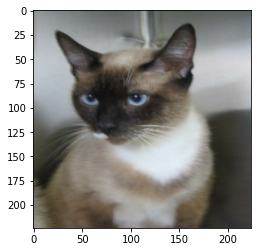

Predicted label Cat


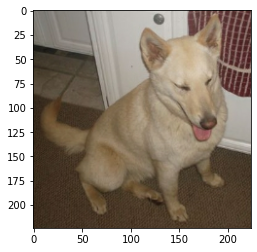

Predicted label Dog


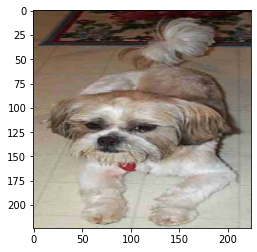

Predicted label Dog


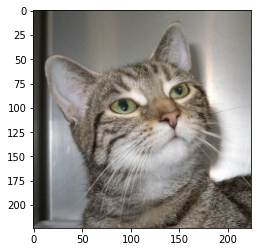

Predicted label Cat


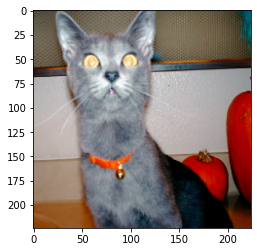

Predicted label Cat


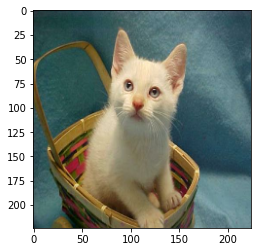

Predicted label Cat


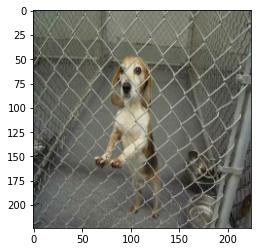

Predicted label Dog


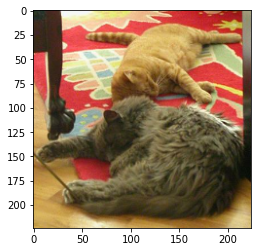

Predicted label Cat


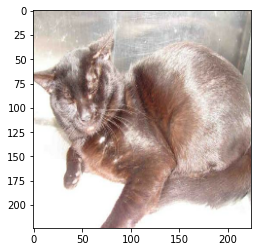

Predicted label Cat


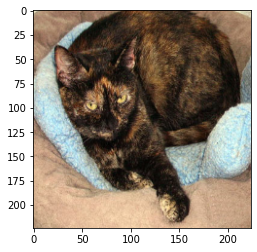

Predicted label Cat


In [ ]:
# Load the TFLite model and allocate tensors
interpreter = tf.lite.Interpreter(model_content=tflite_model)
interpreter.allocate_tensors()

# Get input and output tensors
input_index = interpreter.get_input_details()[0]["index"]
output_index = interpreter.get_output_details()[0]["index"]

# Gather results for the randomly sampled test images
predictions = []

# No. examples for testing
no_test = 10  #@param {type:"integer"}

# Define the labels list
labels = ["Cat","Dog"]

# Foreach testing sample
for img, label in test_batches.take(no_test):
    #img =  np.expand_dims(img, axis=0)
    interpreter.set_tensor(input_index, img)

    # Run the model
    interpreter.invoke()
    animal = np.argmax(interpreter.get_tensor(output_index)[0])

    # Collect the result
    predictions.append(animal)

    # Draw the results
    imgplot = plt.imshow(img.numpy()[0])
    plt.show()
    print('Predicted label', labels[animal])


## Download the model for using on Android devices

In [ ]:
files.download(model_path)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>